In [1]:
import glob
import numpy as np
import pandas as pd
import pickle as pkl


import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [2]:
# samples_dir = "/Users/cmantill/CMS/HWW/boostedhiggs/binder/testTT_inference_2017"
samples_dir = "/Users/cmantill/CMS/HWW/boostedhiggs/binder/testTT_inference_genmass_2017"
sample = "TTToSemiLeptonic"

ch = "mu"

out_files = f"{samples_dir}/{sample}/outfiles/"
parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
pkl_files = glob.glob(f"{out_files}/*.pkl")

data = pd.read_parquet(parquet_files)

data = data.fillna(-1)

In [3]:
np.all(data.fj_Top_isMatched.astype(int) >= 0)

True

In [4]:
data["all_true"] = (data.fj_Top_isMatched.astype(int) >= 0)

In [5]:
# add labels

labels = {
    "label_Top_bmv": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob==0) & (fj_Top_nbquarks==1) & (fj_Top_nleptons==1))",
    "label_Top_bbmv": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob==0) & (fj_Top_nbquarks==2) & (fj_Top_nleptons==1))",
    "label_Top_mv": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob==0) & (fj_Top_nbquarks==0) & (fj_Top_nleptons==1))",
    "label_Top_bqsmv": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob>=1) & (fj_Top_nbquarks==1) & (fj_Top_nleptons==1))",
    "label_Top_bsqsmv": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob>=1) & (fj_Top_nbquarks==2) & (fj_Top_nleptons==1))",
    "label_Top_qsmv": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob>=1) & (fj_Top_nbquarks==0) & (fj_Top_nleptons==1))",
    "label_Top_bsqs": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob>=1) & (fj_Top_nbquarks==2) & (fj_Top_nleptons==0))",
    "label_Top_bqs": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob>=1) & (fj_Top_nbquarks==1) & (fj_Top_nleptons==0))",
    "label_Top_qs": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob>=1) & (fj_Top_nbquarks==0) & (fj_Top_nleptons==0))",
    "label_Top_bs": "((fj_Top_numMatched<=1) & (fj_Top_nquarksnob==0) & (fj_Top_nbquarks>=1) & (fj_Top_nleptons==0))",
    "label_2Tops": "((fj_Top_numMatched==2))",
}


for l,ldef in labels.items():
    data[l] = data.query(ldef)["all_true"]
    data[l] = data[l].fillna(0)
    data[l] = data[l].astype(int)

unmatched = (data.label_Top_bmv==0) 
unmatched = unmatched & (data.label_Top_bbmv==0) 
unmatched = unmatched & (data.label_Top_mv==0)
unmatched = unmatched & (data.label_Top_bqsmv==0)
unmatched = unmatched & (data.label_Top_bsqsmv==0)
unmatched = unmatched & (data.label_Top_qsmv==0)
unmatched = unmatched & (data.label_Top_bsqs==0) 
unmatched = unmatched & (data.label_Top_bqs==0) 
unmatched = unmatched & (data.label_Top_qs==0)
unmatched = unmatched & (data.label_Top_bs==0)
unmatched = unmatched & (data.label_2Tops==0)

data["unmatched"] = unmatched.astype(int)

In [8]:
data.columns

Index(['fj_pt', 'fj_msoftdrop', 'fj_msoftdrop_nocorr', 'fj_mass', 'fj_lsf3',
       'fj_sj1_pt', 'fj_sj2_pt', 'fj_tau3', 'fj_tau2', 'fj_bjets_ophem',
       'fj_bjets', 'lep_pt', 'lep_isolation', 'lep_misolation',
       'fj_minus_lep_m', 'fj_minus_lep_pt', 'dphi_lep_and_fj_minus_lep',
       'lep_fj_dr', 'lep_met_mt', 'met_fj_dphi', 'rec_higgs_m', 'rec_higgs_pt',
       'rec_W_lnu_m', 'rec_W_lnu_pt', 'rec_W_qq_m', 'rec_W_qq_pt',
       'rec_dphi_WW', 'lep_mvaId', 'mu_highPtId', 'ele_highPtId', 'met', 'ht',
       'nfj', 'nj', 'deta', 'mjj', 'n_bjets_L', 'n_bjets_M', 'n_bjets_T',
       'n_bjets_ophem_L', 'n_bjets_ophem_M', 'n_bjets_ophem_T', 'mreg',
       'fj_Top_isMatched', 'fj_Top_numMatched', 'fj_Top_nquarksnob',
       'fj_Top_nbquarks', 'fj_Top_ncquarks', 'fj_Top_nleptons', 'fj_Top_nele',
       'fj_Top_nmu', 'fj_Top_ntau', 'fj_Top_taudecay', 'fj_genjetmass',
       'weight', 'weight_genweight', 'weight_L1Prefiring', 'weight_pileup',
       'weight_trigger_iso_muon', 'weight_tri

In [7]:
# add score

def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1)
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num / den

sigs = ["fj_ParT_probHWqqWmv0c", "fj_ParT_probHWqqWmv1c", "fj_ParT_probHWqqWtaumv0c", "fj_ParT_probHWqqWtaumv1c",
        "fj_ParT_probHWqqWev0c", "fj_ParT_probHWqqWev1c", "fj_ParT_probHWqqWtauev0c", "fj_ParT_probHWqqWtauev1c",
        "fj_ParT_probHWqqWqq0c", "fj_ParT_probHWqqWqq1c", "fj_ParT_probHWqqWqq2c",
        "fj_ParT_probHWqqWq0c", "fj_ParT_probHWqqWq1c", "fj_ParT_probHWqqWq2c",    
       ]

qcd = ["fj_ParT_probQCDbb", "fj_ParT_probQCDcc", "fj_ParT_probQCDb", "fj_ParT_probQCDc", "fj_ParT_probQCDothers"]
tope = ["fj_ParT_probTopbWev", "fj_ParT_probTopbWtauev"]
topm = ["fj_ParT_probTopbWmv", "fj_ParT_probTopbWtaumv"]
tophad = ["fj_ParT_probTopbWqq0c", "fj_ParT_probTopbWqq1c", "fj_ParT_probTopbWq0c", 
          "fj_ParT_probTopbWq1c", "fj_ParT_probTopbWtauhv"]

inclusive_bkg = [b for b in qcd + tope + topm + tophad]

data["inclusive_score"] = disc_score(data, sigs, inclusive_bkg)
data["top_score"] = disc_score(data, sigs, tope+topm+tophad)

KeyError: "None of [Index(['fj_ParT_probHWqqWmv0c', 'fj_ParT_probHWqqWmv1c',\n       'fj_ParT_probHWqqWtaumv0c', 'fj_ParT_probHWqqWtaumv1c',\n       'fj_ParT_probHWqqWev0c', 'fj_ParT_probHWqqWev1c',\n       'fj_ParT_probHWqqWtauev0c', 'fj_ParT_probHWqqWtauev1c',\n       'fj_ParT_probHWqqWqq0c', 'fj_ParT_probHWqqWqq1c',\n       'fj_ParT_probHWqqWqq2c', 'fj_ParT_probHWqqWq0c', 'fj_ParT_probHWqqWq1c',\n       'fj_ParT_probHWqqWq2c'],\n      dtype='object')] are in the [columns]"

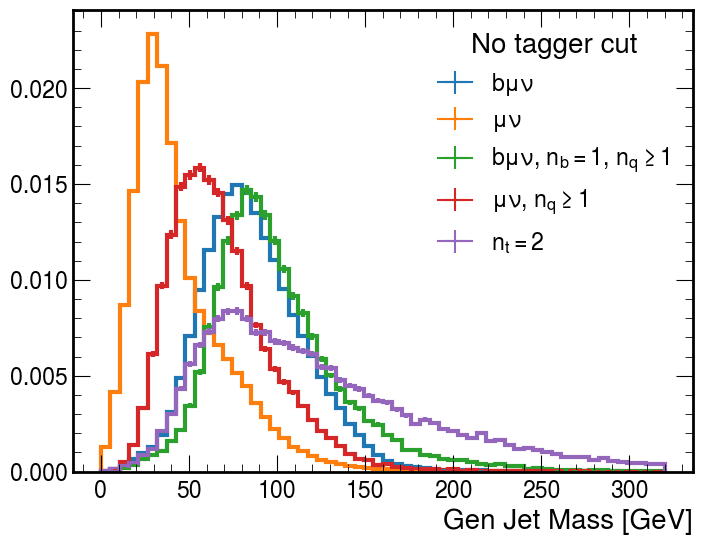

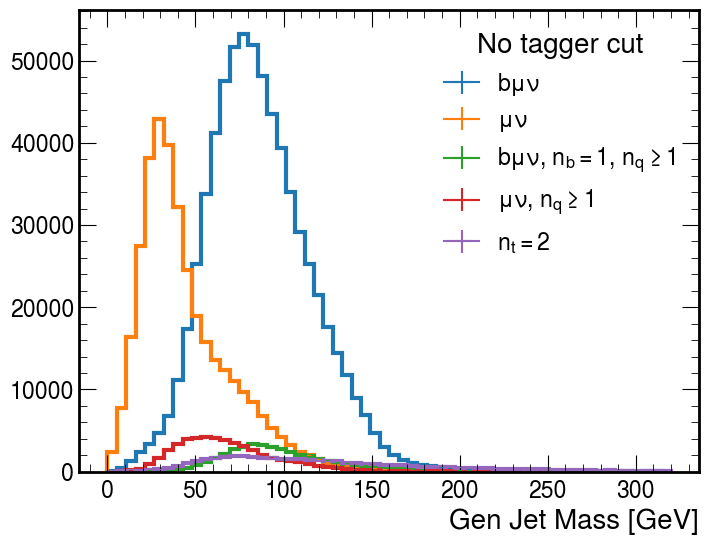

In [10]:
tagger_cut = 0.9
#tagger_selection = data.inclusive_score > tagger_cut

h = hist2.Hist(
    #hist2.axis.Regular(40, 20, 250, name="mass", label=r"Jet $m_{SD}$ [GeV]", overflow=True),
    #hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParT Mass [GeV]", overflow=True),
    hist2.axis.Regular(60, 0, 320, name="gmass", label=r"Gen Jet Mass [GeV]", overflow=True),
    hist2.axis.Boolean(name="bmv"),
    hist2.axis.Boolean(name="bbmv"),
    hist2.axis.Boolean(name="mv"),
    hist2.axis.Boolean(name="bqsmv"),
    hist2.axis.Boolean(name="bsqsmv"),
    hist2.axis.Boolean(name="qsmv"),
    hist2.axis.Boolean(name="bsqs"),
    hist2.axis.Boolean(name="bqs"),
    hist2.axis.Boolean(name="qs"),
    hist2.axis.Boolean(name="bs"),
    hist2.axis.Boolean(name="twotops"),
)
h_sel = hist2.Hist(
    #hist2.axis.Regular(40, 20, 250, name="mass", label=r"Jet $m_{SD}$ [GeV]", overflow=True),
    #hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParT Mass [GeV]", overflow=True),
    hist2.axis.Regular(60, 0, 320, name="gmass", label=r"Gen Jet Mass [GeV]", overflow=True),
    hist2.axis.Boolean(name="bmv"),
    hist2.axis.Boolean(name="bbmv"),
    hist2.axis.Boolean(name="mv"),
    hist2.axis.Boolean(name="bqsmv"),
    hist2.axis.Boolean(name="bsqsmv"),
    hist2.axis.Boolean(name="qsmv"),
    hist2.axis.Boolean(name="bsqs"),
    hist2.axis.Boolean(name="bqs"),
    hist2.axis.Boolean(name="qs"),
    hist2.axis.Boolean(name="bs"),
    hist2.axis.Boolean(name="twotops"),
)
h.fill(
    #mass=data.fj_msoftdrop,
    gmass=data.fj_genjetmass,
    #mass=data.fj_ParT_mass,
    bmv=data.label_Top_bmv,
    bbmv=data.label_Top_bbmv,
    mv=data.label_Top_mv,
    bqsmv=data.label_Top_bqsmv,
    bsqsmv=data.label_Top_bsqsmv,
    qsmv=data.label_Top_qsmv,
    bsqs=data.label_Top_bsqs,
    bqs=data.label_Top_bqs,
    qs=data.label_Top_qs,
    bs=data.label_Top_bs,
    twotops=data.label_2Tops,
)

"""

h_sel.fill(
    #mass=data[tagger_selection].fj_msoftdrop,
    mass=data[tagger_selection].fj_ParT_mass,
    bmv=data[tagger_selection].label_Top_bmv,
    bbmv=data[tagger_selection].label_Top_bbmv,
    mv=data[tagger_selection].label_Top_mv,
    bqsmv=data[tagger_selection].label_Top_bqsmv,
    bsqsmv=data[tagger_selection].label_Top_bsqsmv,
    qsmv=data[tagger_selection].label_Top_qsmv,
    bsqs=data[tagger_selection].label_Top_bsqs,
    bqs=data[tagger_selection].label_Top_bqs,
    qs=data[tagger_selection].label_Top_qs,
    bs=data[tagger_selection].label_Top_bs,
    twotops=data[tagger_selection].label_2Tops,
)
"""

label_Top_bmv = {"bmv":1,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_bbmv = {"bmv":sum,"bbmv":1,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_mv = {"bmv":sum,"bbmv":sum,"mv":1,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_bqsmv = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":1,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_bsqsmv = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":1,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_qsmv = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":1,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_bsqs = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":1,"bqs":sum,"qs":sum,"bs":sum,"twotops":sum}
label_Top_bqs = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":1,"qs":sum,"bs":sum,"twotops":sum}
label_Top_qs = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":1,"bs":sum,"twotops":sum}
label_Top_bs = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":1,"twotops":sum}
label_Top_twotops = {"bmv":sum,"bbmv":sum,"mv":sum,"bqsmv":sum,"bsqsmv":sum,"qsmv":sum,"bsqs":sum,"bqs":sum,"qs":sum,"bs":sum,"twotops":1}
label_Top_unmatched = {"bmv":0,"bbmv":0,"mv":0,"bqsmv":0,"bsqsmv":0,"qsmv":0,"bsqs":0,"bqs":0,"qs":0,"bs":0,"twotops":0}


legends = {
    "label_Top_bmv": r"$b\mu\nu$",
    "label_Top_bbmv": r"$\mu\nu$, $n_b=2$",
    "label_Top_mv": r"$\mu\nu$",
    "label_Top_bqsmv": r"$b\mu\nu$, $n_b=1$, $n_q\geq1$",
    "label_Top_bsqsmv": r"$b\mu\nu$, $n_b=2$, $n_q\geq 1$",
    "label_Top_qsmv": r"$\mu\nu$, $n_q\geq 1$",
    "label_Top_bsqs": r"$n_b=2$, $n_q\geq 1$",
    "label_Top_bqs": r"$n_b=1$, $n_q\geq 1$",
    "label_Top_qs": r"$n_b=0$, $n_q\geq 1$",
    "label_Top_bs": r"$n_b\geq 1$, $n_q==0$",
    "label_2Tops": r"$n_t=2$",
    "label_Top_twotops": r"$n_t=2$",
    "label_Top_unmatched": r"unmatched $t$",
    "unmatched": r"unmatched $t$",
}
    
for den in [True,False]:
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.histplot(
        h[label_Top_bmv],ax=ax,label=legends["label_Top_bmv"],linewidth=3,density=den
    )
    #hep.histplot(
    #    h[label_Top_bbmv],ax=ax,label=legends["label_Top_bbmv"],linewidth=3,density=den,
    #)
    hep.histplot(
        h[label_Top_mv],ax=ax,label=legends["label_Top_mv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bqsmv],ax=ax,label=legends["label_Top_bqsmv"],linewidth=3,density=den,
    )
    #hep.histplot(
    #    h[label_Top_bsqsmv],ax=ax,label=legends["label_Top_bsqsmv"],linewidth=3,density=den,
    #)
    hep.histplot(
        h[label_Top_qsmv],ax=ax,label=legends["label_Top_qsmv"],linewidth=3,density=den,
    )
    #hep.histplot(
    #    h[label_Top_bqs],ax=ax,label=legends["label_Top_bqs"],linewidth=3,density=den,
    #)
    #hep.histplot(
    #    h[label_Top_qs],ax=ax,label=legends["label_Top_qs"],linewidth=3,density=den,
    #)
    #hep.histplot(
    #    h[label_Top_bs],ax=ax,label=legends["label_Top_bs"],linewidth=3,density=den,
    #)
    hep.histplot(
        h[label_Top_twotops],ax=ax,label=legends["label_Top_twotops"],linewidth=3,density=den,
    )
    ax.legend(title="No tagger cut")
    
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.histplot(
        h_sel[label_Top_bmv],ax=ax,label=legends["label_Top_bmv"],linewidth=3,density=den
    )
    #hep.histplot(
    #    h_sel[label_Top_bbmv],ax=ax,label=legends["label_Top_bbmv"],linewidth=3,density=den,
    #)
    hep.histplot(
        h_sel[label_Top_mv],ax=ax,label=legends["label_Top_mv"],linewidth=3,density=den,
    )
    hep.histplot(
        h_sel[label_Top_bqsmv],ax=ax,label=legends["label_Top_bqsmv"],linewidth=3,density=den,
    )
    #hep.histplot(
    #    h_sel[label_Top_bsqsmv],ax=ax,label=legends["label_Top_bsqsmv"],linewidth=3,density=den,
    #)
    hep.histplot(
        h_sel[label_Top_qsmv],ax=ax,label=legends["label_Top_qsmv"],linewidth=3,density=den,
    )
    #hep.histplot(
    #    h_sel[label_Top_bqs],ax=ax,label=legends["label_Top_bqs"],linewidth=3,density=den,
    #)
    #hep.histplot(
    #    h_sel[label_Top_qs],ax=ax,label=legends["label_Top_qs"],linewidth=3,density=den,
    #)
    #hep.histplot(
    #    h_sel[label_Top_bs],ax=ax,label=legends["label_Top_bs"],linewidth=3,density=den,
    #)
    hep.histplot(
        h_sel[label_Top_twotops],ax=ax,label=legends["label_Top_twotops"],linewidth=3,density=den,
    )
    #hep.histplot(
    #    h_sel[label_Top_unmatched],ax=ax,label=legends["label_Top_unmatched"],linewidth=3,density=den,
    #)
    ax.legend(title=f"Tagger>{tagger_cut}")
    """
    


In [ ]:
h = hist2.Hist(
    #hist2.axis.Regular(40, 20, 250, name="mass", label=r"Jet $m_{SD}$ [GeV]", overflow=True),
    hist2.axis.Regular(60, 0, 320, name="mass", label=r"ParT Mass [GeV]", overflow=True),
    hist2.axis.Boolean(name="bmv"),
    hist2.axis.Boolean(name="bbmv"),
    hist2.axis.Boolean(name="mv"),
    hist2.axis.Boolean(name="bqsmv"),
    hist2.axis.Boolean(name="bsqsmv"),
    hist2.axis.Boolean(name="qsmv"),
    hist2.axis.Boolean(name="bsqs"),
    hist2.axis.Boolean(name="bqs"),
    hist2.axis.Boolean(name="qs"),
    hist2.axis.Boolean(name="bs"),
    hist2.axis.Boolean(name="twotops"),
)
h.fill(
    #mass=data.fj_msoftdrop,
    mass=data.fj_ParT_mass,
    bmv=data.label_Top_bmv,
    bbmv=data.label_Top_bbmv,
    mv=data.label_Top_mv,
    bqsmv=data.label_Top_bqsmv,
    bsqsmv=data.label_Top_bsqsmv,
    qsmv=data.label_Top_qsmv,
    bsqs=data.label_Top_bsqs,
    bqs=data.label_Top_bqs,
    qs=data.label_Top_qs,
    bs=data.label_Top_bs,
    twotops=data.label_2Tops,
)

for den in [False,True]:
    fig, ax = plt.subplots(figsize=(8, 6))
    #hep.histplot(
    #    h[label_Top_bmv],ax=ax,label=legends["label_Top_bmv"],linewidth=3,density=den
    #)
    hep.histplot(
        h[label_Top_bbmv],ax=ax,label=legends["label_Top_bbmv"],linewidth=3,density=den,
    )
    #hep.histplot(
    #    h[label_Top_mv],ax=ax,label=legends["label_Top_mv"],linewidth=3,density=den,
    #)
    hep.histplot(
        h[label_Top_bqsmv],ax=ax,label=legends["label_Top_bqsmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bsqsmv],ax=ax,label=legends["label_Top_bsqsmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_qsmv],ax=ax,label=legends["label_Top_qsmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_twotops],ax=ax,label=legends["label_Top_twotops"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_unmatched],ax=ax,label=legends["label_Top_unmatched"],linewidth=3,density=den,
    )
    """
    hep.histplot(
        h[label_Top_bqs],ax=ax,label=legends["label_Top_bqs"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_qs],ax=ax,label=legends["label_Top_qs"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bs],ax=ax,label=legends["label_Top_bs"],linewidth=3,density=den,
    )
    """
    ax.legend()
    
for den in [False]:
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.histplot(
        h[label_Top_bmv],ax=ax,label=legends["label_Top_bmv"],linewidth=3,density=den
    )
    hep.histplot(
        h[label_Top_bbmv],ax=ax,label=legends["label_Top_bbmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_mv],ax=ax,label=legends["label_Top_mv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bqsmv],ax=ax,label=legends["label_Top_bqsmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bsqsmv],ax=ax,label=legends["label_Top_bsqsmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_qsmv],ax=ax,label=legends["label_Top_qsmv"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bqs],ax=ax,label=legends["label_Top_bqs"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_qs],ax=ax,label=legends["label_Top_qs"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_bs],ax=ax,label=legends["label_Top_bs"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_twotops],ax=ax,label=legends["label_Top_twotops"],linewidth=3,density=den,
    )
    hep.histplot(
        h[label_Top_unmatched],ax=ax,label=legends["label_Top_unmatched"],linewidth=3,density=den,
    )
    ax.legend()